In [1]:
import pandas as pd

# A Quick Look

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
import matplotlib.pyplot as plt

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

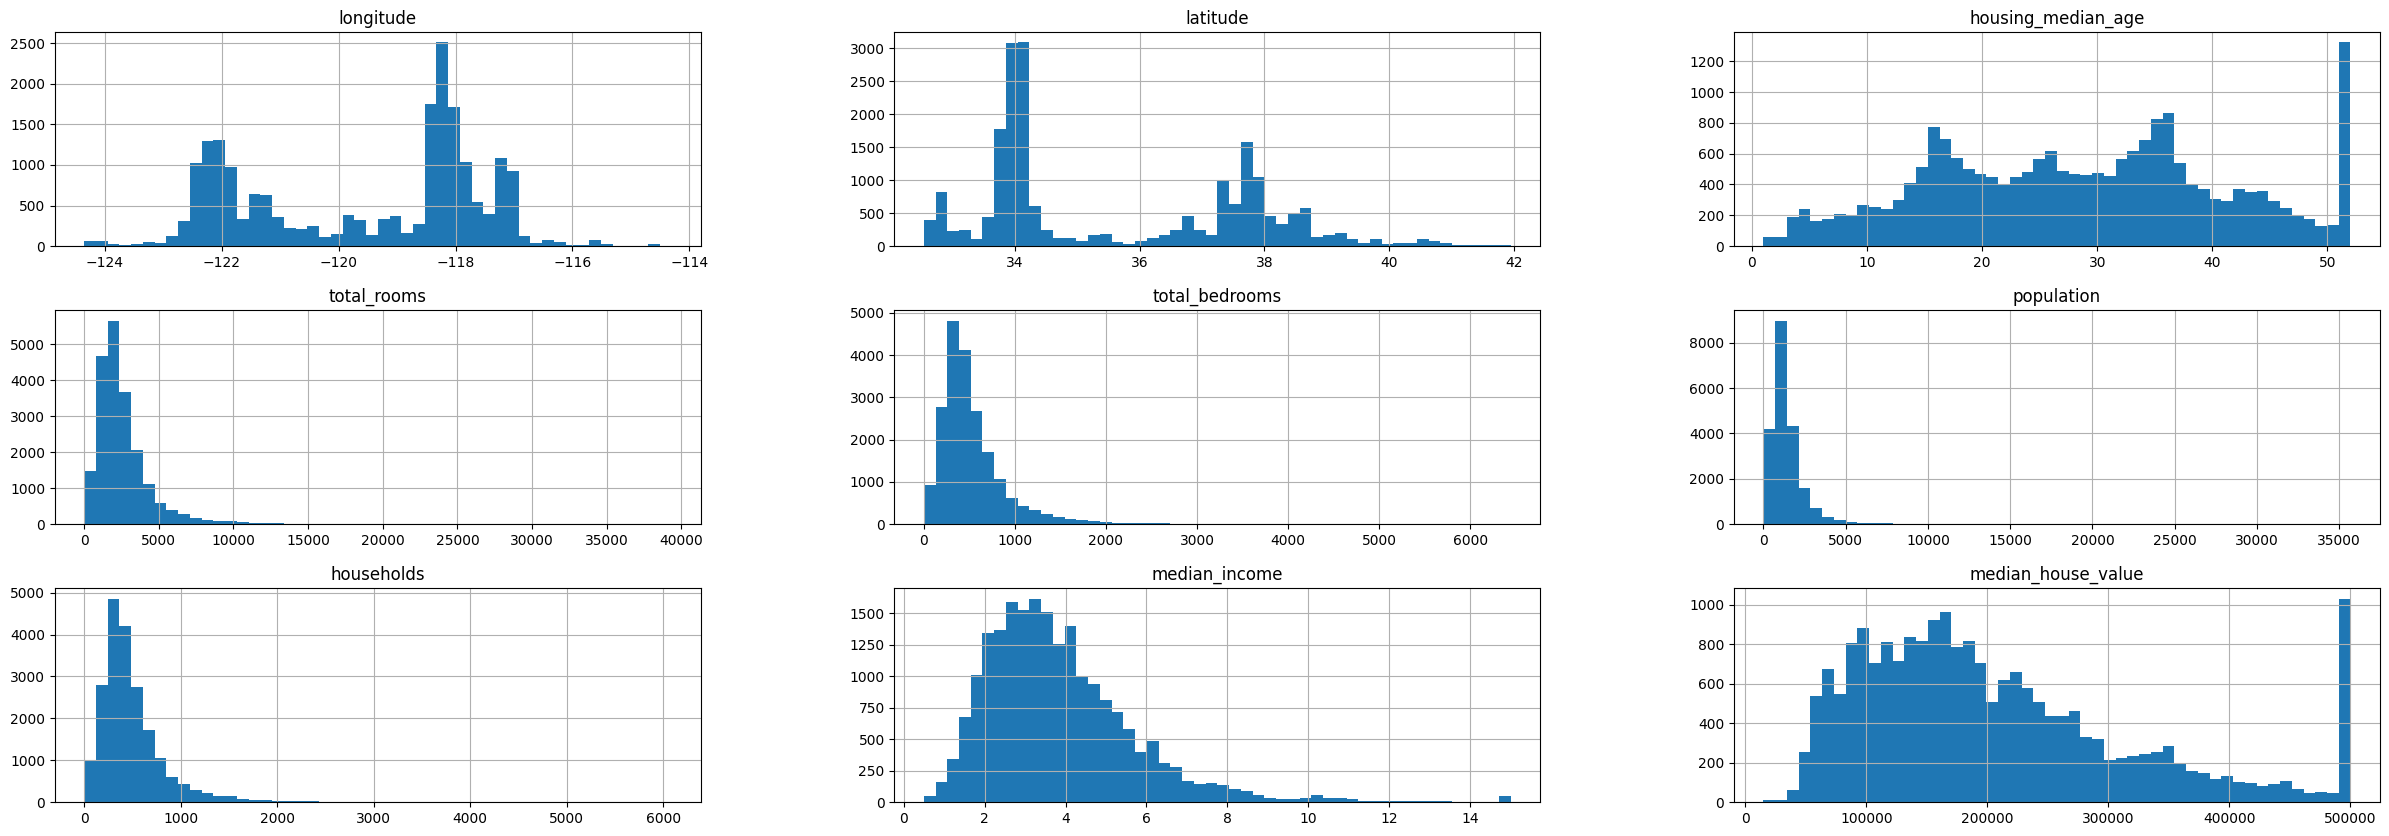

In [6]:
# bins = 50 => the data will be divided into 50 bins

data.hist(bins= 50, figsize=(30, 10))

In [7]:
import numpy as np

# Split Data

In [8]:
# from sklearn.model_selection import train_test_split
#train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

def split_train_test(data, test_ratio):
    # np.random.seed(42)   => to have the same split
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(data, 0.2)    
len(train_set), len(test_set)

(16512, 4128)

<Axes: >

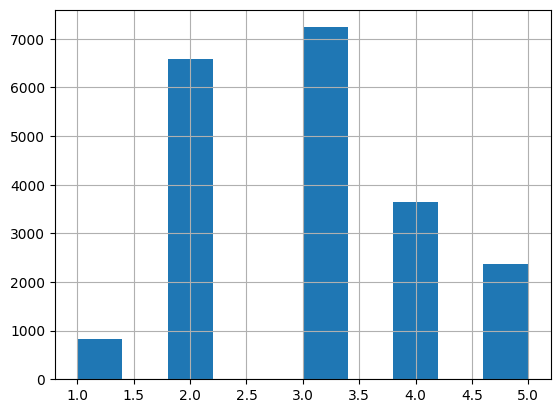

In [9]:
# split "median_income" into stratum
data['income_cat'] = pd.cut(data['median_income'], 
                           bins= [0., 1.5, 3., 4.5, 6., np.inf],
                           labels= [1, 2, 3, 4, 5])
data['income_cat'].hist()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# will iterate once as we only have one split
# .split returns two arrays {training, testing}
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

stratified_data = strat_test_set['income_cat'].value_counts()/ len(strat_test_set)

In [11]:
original_data = data['income_cat'].value_counts()/ len(data)

In [12]:
from sklearn.model_selection import train_test_split

random_train_set, random_test_set = train_test_split(data, test_size=0.2, random_state=42)
random_data = random_test_set["income_cat"].value_counts() / len(random_test_set)

In [13]:
strat_error = pd.DataFrame({
    'Original': original_data,
    'Random': random_data,
    'Stratified': stratified_data,
    'Random_Error': original_data - random_data,
    'Strat_Error': original_data - stratified_data
}).sort_index()

In [14]:
# Show the percentage of each category in original, random, stratified
# to show that the test set isn't biased after stratification

strat_error *= 100
strat_error = strat_error.round(2)

strat_error

,Original,Random,Stratified,Random_Error,Strat_Error
income_cat,,,,,
1,3.98,4.02,4.00,-0.04,-0.01
2,31.88,32.44,31.88,-0.55,0.00
3,35.06,35.85,35.05,-0.79,0.00
4,17.63,16.74,17.64,0.89,-0.00
5,11.44,10.95,11.43,0.49,0.01


In [15]:
for i in (strat_train_set, strat_test_set):
    i.drop("income_cat", axis=1, inplace=True)

In [16]:
# create a copy to explore without altering the original data
housing = strat_train_set.copy()

# Visualize

<Axes: xlabel='longitude', ylabel='latitude'>

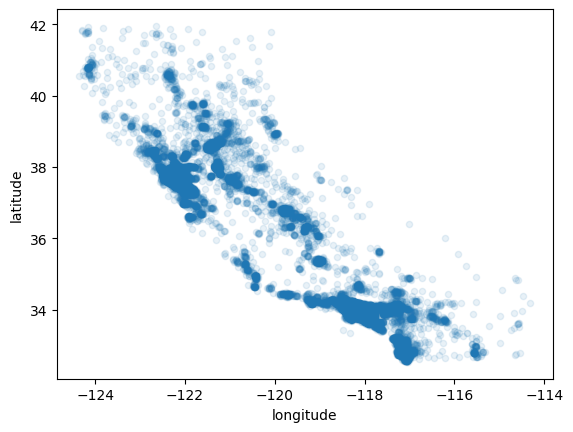

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha= 0.1)

<Axes: xlabel='longitude', ylabel='latitude'>

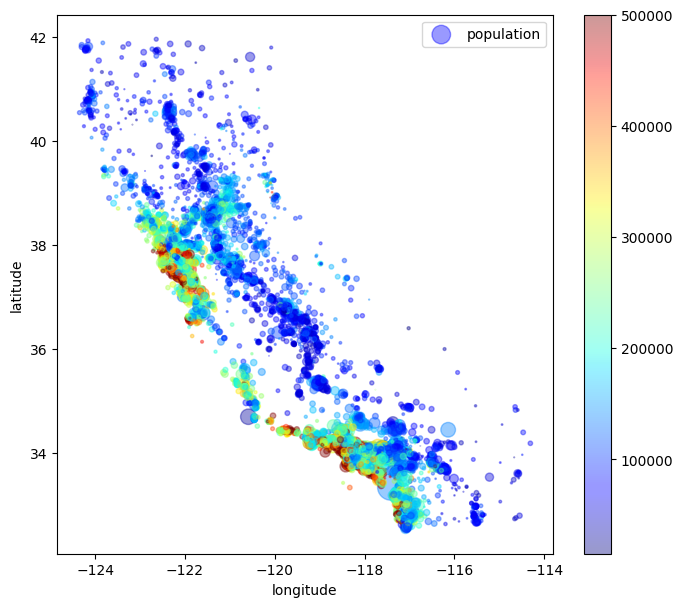

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha= 0.4,
            s = housing['population']/100, c= housing['median_house_value'], label= 'population', figsize=(8,7),
            cmap= plt.get_cmap('jet'), colorbar= True)

In [19]:
ocean_proximity = housing['ocean_proximity']
housing.drop('ocean_proximity', axis=1, inplace=True)

In [20]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [21]:
import seaborn as sns

<Axes: >

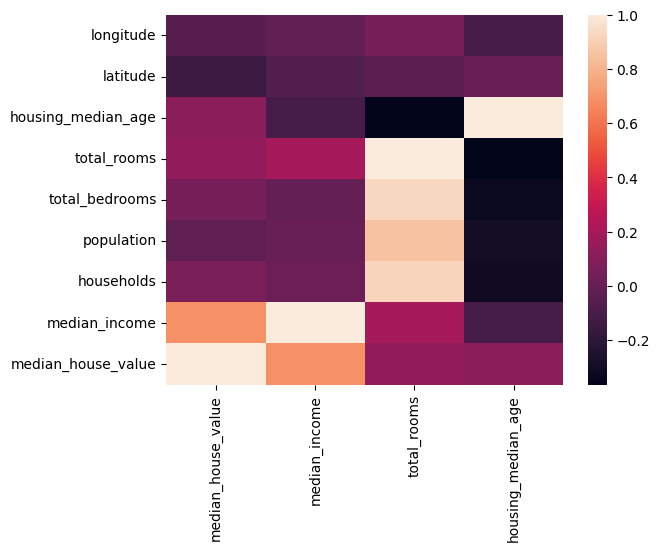

In [22]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
sns.heatmap(corr_matrix[attributes])

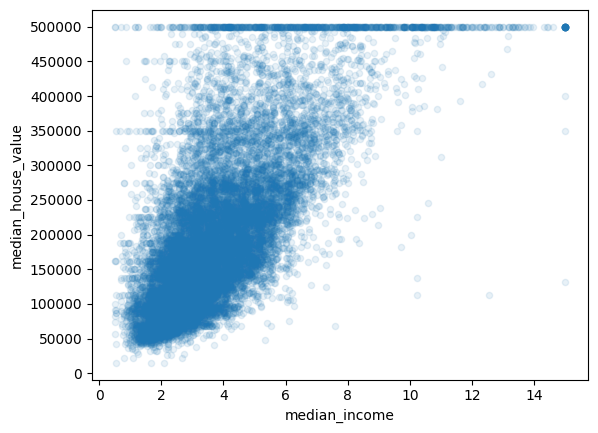

In [23]:
# median_income is the most promising
sc = housing.plot(kind='scatter', x= 'median_income', y= 'median_house_value', alpha= 0.1)
sc.set_yticks(np.arange(0, housing['median_house_value'].max(), 50000))

* The correlation is strong and the prices are capped at 500K
* The horizontal lines at 275k, 350k and 500k can introduce biases in the model

In [24]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [25]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,6.096552,0.182692,3.167241


In [26]:
corr_matrix = housing.corr()

<Axes: >

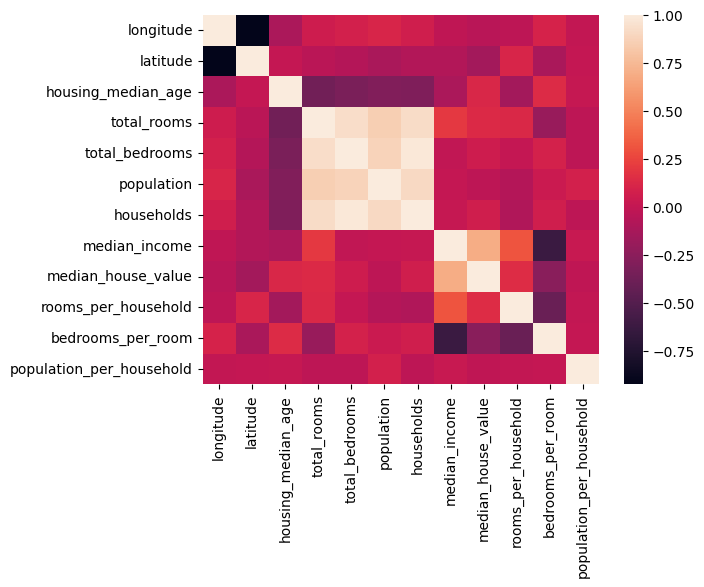

In [27]:
sns.heatmap(corr_matrix)

In [28]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

* Lower bedroom/room ratio tends to be more expensive

In [29]:
# get a fresh copy and separate the predictors and the labels
housing = strat_train_set.drop('median_house_value', axis= 1)
housing_labels = strat_train_set['median_house_value'].copy()

# Data Preparation and Cleaning

In [30]:
from sklearn.impute import SimpleImputer

In [31]:
imputer = SimpleImputer(strategy='median')

In [32]:
# take numerical values to assign the missing with the median
housing_nums = housing.drop('ocean_proximity', axis=1)

In [33]:
imputer.fit(housing_nums)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [34]:
# Replace all missings with the medians
X = imputer.transform(housing_nums)

In [35]:
# X is a numpy array so return it to DF
housing_tr = pd.DataFrame(X, columns=housing_nums.columns,
index=housing_nums.index)

In [36]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [37]:
from sklearn.preprocessing import OrdinalEncoder

In [38]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [39]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

* Categories 0 and 4  are more similar than categories 0 and  and ML algorithms will assume that nearby values are similar
* One-hot encoding will be a better option here1

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
one_hot = OneHotEncoder()
housing_1hot = one_hot.fit_transform(housing_cat)

# Custom Transformer

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
     def __init__(self, add_bedrooms_per_room = True): 
         self.add_bedrooms_per_room = add_bedrooms_per_room
     def fit(self, X, y=None):
         return self  
     def transform(self, X):
         rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
         population_per_household = X[:, population_ix] / X[:, households_ix]
         if self.add_bedrooms_per_room:
             bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
             return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
         else:
             return np.c_[X, rooms_per_household, population_per_household]

#### Hyperparameter
The hyperparameter `add_bedrooms_per_room` will help in knowing whether it's useful or not.

* Creating hyperparameters will help in automating the data preparation

In [43]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Pipelines

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [45]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_adder', CombinedAttributesAdder()),
    ('scale', StandardScaler())
])

In [46]:
housing_nums = num_pipeline.fit_transform(housing_nums)

**A transformer that can handle numerical and categorical data**

In [47]:
from sklearn.compose import ColumnTransformer

In [48]:
nums_attr = list(housing.drop('ocean_proximity', axis=1))
cat_attr = ['ocean_proximity']
# 

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, nums_attr),
    ('cat', OneHotEncoder(), cat_attr)
])

In [49]:
housing_pp = full_pipeline.fit_transform(housing)

# Training

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
forest = RandomForestRegressor()

In [52]:
forest.fit(housing_pp, housing_labels)

RandomForestRegressor()

## Use Cross-Validation for better evaluation

In [53]:
from sklearn.model_selection import cross_val_score

In [54]:
scores = cross_val_score(forest, housing_pp, housing_labels, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-scores)

In [55]:
def display_score(score):
    print("Score: ", score)
    print("Mean: ", score.mean())
    print("Standard deviation: ", score.std())

display_score(rmse)

Score:  [50439.88812032 49691.60676763 49955.49016159 51620.25177391
 51503.28817949]
Mean:  50642.10500058965
Standard deviation:  789.2003639694187


In [57]:
from sklearn.metrics import mean_squared_error

In [58]:
predictions = forest.predict(housing_pp)
forest_mse = mean_squared_error(predictions, housing_labels)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18653.443373811824

* Apparently it's overfitting as the score is much less than the validation sets

**Solutions:**
1. Regularization
2. Feature selection
3. More data

# Fine-Tuning

### Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV

In [74]:
params = [
    {'n_estimators': [40, 50, 80, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest = RandomForestRegressor()
grid_search = GridSearchCV(forest, params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_pp, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [40, 50, 80, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [75]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 80}

In [76]:
results = grid_search.cv_results_

# The mean is for the 5 cv sets
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean_score), params)

52104.76581088817 {'max_features': 2, 'n_estimators': 40}
52120.90615692817 {'max_features': 2, 'n_estimators': 50}
51721.256822418225 {'max_features': 2, 'n_estimators': 80}
51604.64592560982 {'max_features': 2, 'n_estimators': 100}
50227.72993356753 {'max_features': 4, 'n_estimators': 40}
50099.1588468396 {'max_features': 4, 'n_estimators': 50}
49551.852249690986 {'max_features': 4, 'n_estimators': 80}
49470.51743214002 {'max_features': 4, 'n_estimators': 100}
49729.048965145405 {'max_features': 6, 'n_estimators': 40}
49448.4362432348 {'max_features': 6, 'n_estimators': 50}
49169.61654225499 {'max_features': 6, 'n_estimators': 80}
49265.28071310053 {'max_features': 6, 'n_estimators': 100}
49652.647587108004 {'max_features': 8, 'n_estimators': 40}
49635.55198536937 {'max_features': 8, 'n_estimators': 50}
49492.09035971009 {'max_features': 8, 'n_estimators': 80}
49350.12798813266 {'max_features': 8, 'n_estimators': 100}
61312.263190751495 {'bootstrap': False, 'max_features': 2, 'n_esti

# Features Analysis

In [77]:
features = grid_search.best_estimator_.feature_importances_
features

array([7.27750497e-02, 6.51143011e-02, 4.37862778e-02, 1.77592451e-02,
       1.67410592e-02, 1.72904243e-02, 1.60234277e-02, 3.39059607e-01,
       6.25278852e-02, 1.09225713e-01, 7.13860162e-02, 1.39011030e-02,
       1.45991867e-01, 1.11550659e-04, 3.31554455e-03, 4.99092818e-03])

In [78]:
extra_attrs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_attrs = list(cat_encoder.categories_[0])
attrs = nums_attr + extra_attrs + cat_attrs
sorted(zip(features, attrs), reverse=True)

[(0.3390596072306946, 'median_income'),
 (0.14599186735897657, 'INLAND'),
 (0.10922571289175316, 'pop_per_hhold'),
 (0.07277504965534684, 'longitude'),
 (0.07138601616158628, 'bedrooms_per_room'),
 (0.06511430113660079, 'latitude'),
 (0.06252788518227521, 'rooms_per_hhold'),
 (0.04378627776915788, 'housing_median_age'),
 (0.017759245085180213, 'total_rooms'),
 (0.01729042430473322, 'population'),
 (0.016741059159988168, 'total_bedrooms'),
 (0.01602342767145821, 'households'),
 (0.013901102996014433, '<1H OCEAN'),
 (0.004990928183736406, 'NEAR OCEAN'),
 (0.0033155445531471844, 'NEAR BAY'),
 (0.00011155065935079605, 'ISLAND')]

# Save the Model

In [80]:
from joblib import dump

# Save to file in the current working directory
final_model = grid_search.best_estimator_
joblib_filename = "housing_model.joblib"
dump(final_model, joblib_filename)

['housing_model.joblib']

# Evaluate the Model on the Test Set

In [81]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [82]:
X_test_p = full_pipeline.transform(X_test)

In [83]:
final_predictions = final_model.predict(X_test_p)
f_mse = mean_squared_error(final_predictions, y_test)
f_rmse = np.sqrt(f_mse)
f_rmse

47235.474895209736